# MACHINE LEARNING MULTICLASS

This notebook test the machine learning model for the multiclass prediction of the types of attack.

### INSTALLATION

In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import unsloth
import xgboost as xgb
import lightgbm as lgb

from datasets import Dataset, load_dataset, load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from trl import SFTTrainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tqdm import tqdm

### DATA PREPARATION

In [39]:
# Read dataset
csv_path = "../data/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path,low_memory=False)
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.file_data,http.content_length,http.request.uri.query,http.request.method,http.referer,http.request.full_uri,http.request.version,http.response,http.tls_port,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,tcp.connection.rst,tcp.connection.syn,tcp.connection.synack,tcp.dstport,tcp.flags,tcp.flags.ack,tcp.len,tcp.options,tcp.payload,tcp.seq,tcp.srcport,udp.port,udp.stream,udp.time_delta,dns.qry.name,dns.qry.name.len,dns.qry.qu,dns.qry.type,dns.retransmission,dns.retransmit_request,dns.retransmit_request_in,mqtt.conack.flags,mqtt.conflag.cleansess,mqtt.conflags,mqtt.hdrflags,mqtt.len,mqtt.msg_decoded_as,mqtt.msg,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,47892.0,0.0,0.0,0.0,1.0,64855.0,18.0,1.0,0.0,020405b40101040201030307,0,0.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,16077.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,14.0,0,100c00044d5154540402003c0000,1.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,16.0,12.0,0.0,0,1.0,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,62675.0,0.0,0.0,0.0,0.0,64855.0,16.0,1.0,0.0,0,0,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,54469.0,0.0,0.0,0.0,0.0,64855.0,24.0,1.0,4.0,0,20020000,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0x00000000,0.0,0.0,32.0,2.0,0.0,0,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,53812.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,41.0,0,3027001854656d70657261747572655f616e645f48756d...,15.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,48.0,39.0,0.0,32342e36382037362e34320d0a,3.0,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [40]:
print(df.columns)

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [41]:
# Save a backup of the dataframe
df_bp = df

### DATA PREPROCESSING

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [43]:
df.isna().sum()

frame.time                   0
ip.src_host                  0
ip.dst_host                  0
arp.dst.proto_ipv4           0
arp.opcode                   0
arp.hw.size                  0
arp.src.proto_ipv4           0
icmp.checksum                0
icmp.seq_le                  0
icmp.transmit_timestamp      0
icmp.unused                  0
http.file_data               0
http.content_length          0
http.request.uri.query       0
http.request.method          0
http.referer                 0
http.request.full_uri        0
http.request.version         0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.dstport                  0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.options                  0
tcp.payl

### Feature selection

We use a random forest classifier to select the best 7 features.

dns.qry.name.len     0.205840
mqtt.protoname       0.138802
mqtt.msg             0.109687
mqtt.topic           0.101408
mqtt.conack.flags    0.095618
tcp.options          0.081726
tcp.dstport          0.055727
dtype: float64


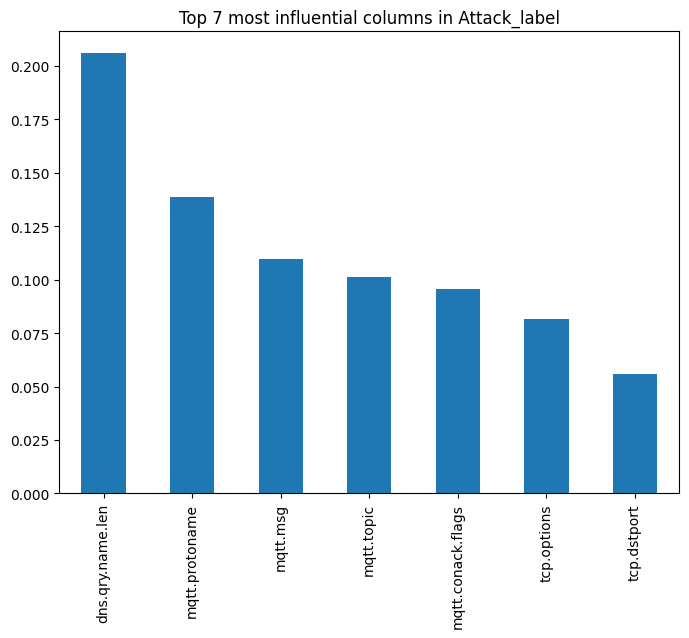

In [44]:
# Convert Attack_label to an integer (0 or 1)
df["Attack_label"] = df["Attack_label"].astype(int)

# Remove unnecessary columns
df = df.drop(["frame.time", "Attack_type"], axis=1, errors="ignore")

# Convert categorical variables into numerical values
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target variable
X = df.drop(columns=["Attack_label"])
y = df["Attack_label"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 15 most influential features
print(feature_importance.head(7))

# Plot feature importance
plt.figure(figsize=(8,6))
feature_importance.head(7).plot(kind="bar")
plt.title("Top 7 most influential columns in Attack_label")
plt.show()

In [45]:
# Define the selected columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport"
]

# Filter the dataset to keep only these columns + target variable
df_selected = df_bp[selected_columns + ["Attack_type"]]

In [46]:
df_selected.head()

,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_type
0,0,0,0,0,0,020405b40101040201030307,64855.0,Normal
1,0,MQTT,0,0,0,0,1883.0,Normal
2,0,0,0,0,0,0,64855.0,Normal
3,0,0,0,0,0x00000000,0,64855.0,Normal
4,0,0,32342e36382037362e34320d0a,Temperature_and_Humidity,0,0,1883.0,Normal


In [ ]:
print(df_selected["Attack_type"].dtype)
print(df_selected["Attack_type"].unique()) 


object
['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']


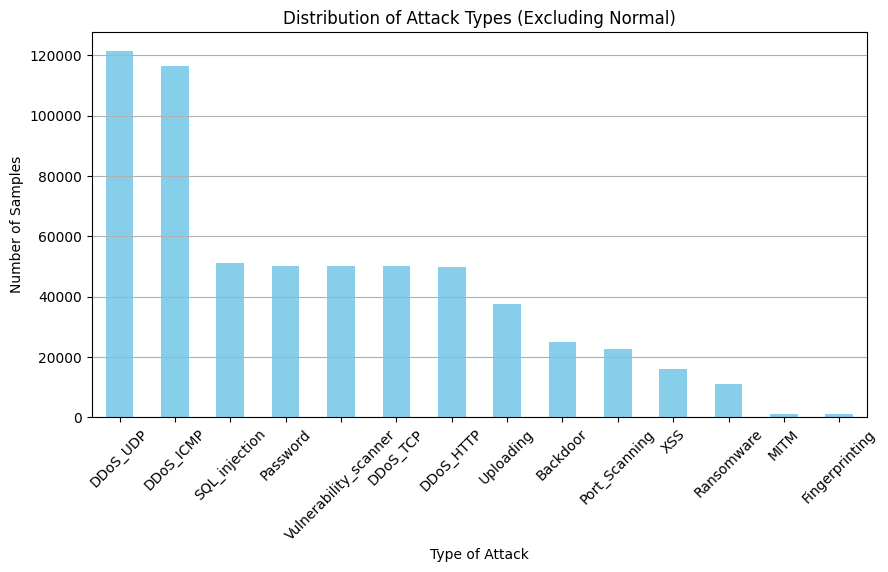

In [48]:
# Filter out the "Normal" category
df_filtered = df_selected[df_selected["Attack_type"] != "Normal"]

# Count occurrences of each attack type (excluding "Normal")
attack_counts_filtered = df_filtered["Attack_type"].value_counts()

# Plot the attack distribution
plt.figure(figsize=(10, 5))
attack_counts_filtered.plot(kind="bar", color="skyblue")
plt.title("Distribution of Attack Types (Excluding Normal)")
plt.xlabel("Type of Attack")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Show the plot
plt.show()

In [49]:
# Split features and target variable
X = df_selected.drop(columns=["Attack_type"])  # Features
y = df_selected["Attack_type"]  # Target

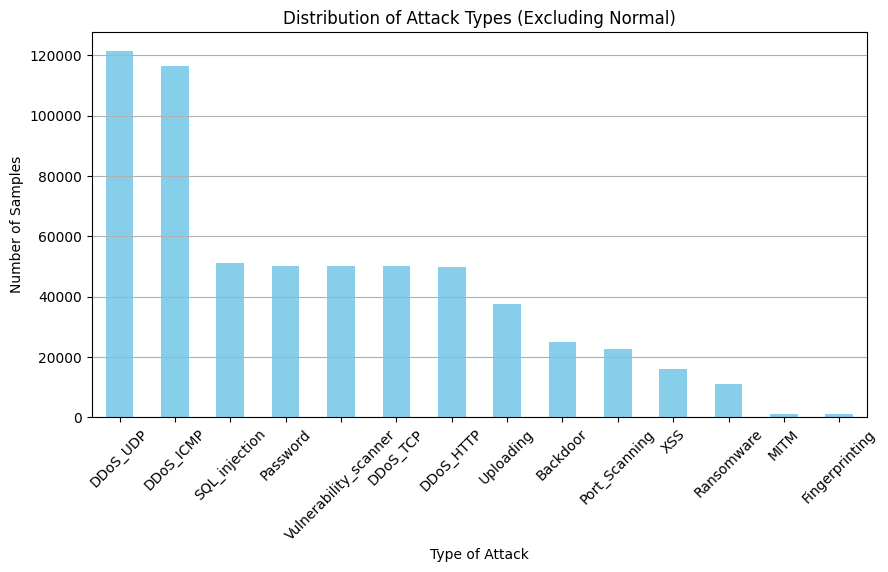

In [50]:
# Filter out the "Normal" category
df_filtered = df_selected[df_selected["Attack_type"] != "Normal"]

# Count occurrences of each attack type (excluding "Normal")
attack_counts_filtered = df_filtered["Attack_type"].value_counts()

# Plot the attack distribution
plt.figure(figsize=(10, 5))
attack_counts_filtered.plot(kind="bar", color="skyblue")
plt.title("Distribution of Attack Types (Excluding Normal)")
plt.xlabel("Type of Attack")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Show the plot
plt.show()

#### ONE-HOT ENCODING

In [51]:
# Define number of samples per class
samples_per_class = 1000

# Check if "Attack_type" exists in df_selected
if "Attack_type" not in df_selected.columns:
    raise ValueError("❌ Column 'Attack_type' not found in df_selected. Check your DataFrame.")

# Select 1000 samples for "Normal" traffic
normal_samples = df_selected[df_selected["Attack_type"] == "Normal"].sample(
    n=min(samples_per_class, len(df_selected[df_selected["Attack_type"] == "Normal"])),
    random_state=42
)

# Select 1000 samples for each attack type
attack_samples = df_selected[df_selected["Attack_type"] != "Normal"].groupby("Attack_type").apply(
    lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)
).reset_index(drop=True)

# Combine normal and attack samples into a balanced dataset
df_balanced = pd.concat([normal_samples, attack_samples])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and target variable
X = df_balanced.drop(columns=["Attack_type"])  # Features
y = df_balanced["Attack_type"]  # Target (multi-class)

# Display dataset info
print(df_balanced["Attack_type"].value_counts())

# Display first rows to check
df_balanced.head()

Attack_type
SQL_injection            1000
Fingerprinting           1000
Vulnerability_scanner    1000
Normal                   1000
DDoS_UDP                 1000
DDoS_ICMP                1000
DDoS_HTTP                1000
DDoS_TCP                 1000
Uploading                1000
MITM                     1000
Backdoor                 1000
Password                 1000
Ransomware               1000
XSS                      1000
Port_Scanning            1000
Name: count, dtype: int64


/tmp/ipykernel_1784/4021394777.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_samples = df_selected[df_selected["Attack_type"] != "Normal"].groupby("Attack_type").apply(


,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0101080a9eb23b7d9b24a80c,44090.0,SQL_injection
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fingerprinting
2,0.0,0.0,0.0,0.0,0.0,0101080a3fc429fe49455658,80.0,Vulnerability_scanner
3,0,0,32332e30362037332e35300d0a,Temperature_and_Humidity,0,0,1883.0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS_UDP


In [52]:
# Columns to One-Hot Encode
categorical_columns = ["dns.qry.name.len","mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]

# Apply One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(X.head())


   tcp.dstport  dns.qry.name.len_0.0  dns.qry.name.len_1.0  \
0      44090.0                  True                 False   
1          0.0                  True                 False   
2         80.0                  True                 False   
3       1883.0                 False                 False   
4          0.0                  True                 False   

   dns.qry.name.len_2.debian.pool.ntp.org  mqtt.protoname_0.0  \
0                                   False                True   
1                                   False                True   
2                                   False                True   
3                                   False               False   
4                                   False                True   

   mqtt.protoname_MQTT  mqtt.msg_0.0  mqtt.msg_32322e35372037322e36330d0a  \
0                False          True                                False   
1                False          True                                False   
2    

In [53]:
print(X.columns)

Index(['tcp.dstport', 'dns.qry.name.len_0.0', 'dns.qry.name.len_1.0',
       'dns.qry.name.len_2.debian.pool.ntp.org', 'mqtt.protoname_0.0',
       'mqtt.protoname_MQTT', 'mqtt.msg_0.0',
       'mqtt.msg_32322e35372037322e36330d0a',
       'mqtt.msg_32322e36382037322e38330d0a',
       'mqtt.msg_32322e37362037322e39370d0a',
       ...
       'tcp.options_020405b40402080ae82aa3040000000001030307',
       'tcp.options_020405b40402080ae82cd1a80000000001030307',
       'tcp.options_020405b40402080ae82ed3e70000000001030307',
       'tcp.options_123.0', 'tcp.options_137.0', 'tcp.options_37691.0',
       'tcp.options_5353.0', 'tcp.options_5355.0', 'tcp.options_57342.0',
       'tcp.options_67.0'],
      dtype='object', length=7462)


In [54]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode attack types into integers
y = label_encoder.fit_transform(y)  # Convert labels into numeric format

# Print mapping of attack types to numbers
attack_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Attack Type Mapping:", attack_mapping)


Attack Type Mapping: {'Backdoor': np.int64(0), 'DDoS_HTTP': np.int64(1), 'DDoS_ICMP': np.int64(2), 'DDoS_TCP': np.int64(3), 'DDoS_UDP': np.int64(4), 'Fingerprinting': np.int64(5), 'MITM': np.int64(6), 'Normal': np.int64(7), 'Password': np.int64(8), 'Port_Scanning': np.int64(9), 'Ransomware': np.int64(10), 'SQL_injection': np.int64(11), 'Uploading': np.int64(12), 'Vulnerability_scanner': np.int64(13), 'XSS': np.int64(14)}


### TRAIN MODELS

Split data

In [ ]:
# Split Data into Train and Test Sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  
)


#### RANDOM FOREST

In [ ]:
# Initialize and Train RandomForest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make Predictions on Test Data
y_pred_RF = model.predict(X_test)

# Convert Predictions Back to Attack Names
y_test_labels = label_encoder.inverse_transform(y_test) 
y_pred_labels_rf = label_encoder.inverse_transform(y_pred_RF)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_RF)
report = classification_report(y_test_labels, y_pred_labels_rf) 
f1 = f1_score(y_test, y_pred_RF, average="weighted")

# Print Results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(report)

✅ Accuracy: 0.4833
✅ F1-Score: 0.4436

📊 Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.80      0.49      0.61       300
            DDoS_HTTP       0.22      0.66      0.33       300
            DDoS_ICMP       0.28      1.00      0.44       300
             DDoS_TCP       0.61      0.89      0.73       300
             DDoS_UDP       0.00      0.00      0.00       300
       Fingerprinting       0.69      0.19      0.30       300
                 MITM       1.00      0.27      0.43       300
               Normal       1.00      1.00      1.00       300
             Password       0.67      0.01      0.01       300
        Port_Scanning       0.88      0.40      0.55       300
           Ransomware       0.56      0.99      0.71       300
        SQL_injection       0.60      0.45      0.51       300
            Uploading       0.39      0.44      0.41       300
Vulnerability_scanner       0.83      0.08      0.15 

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

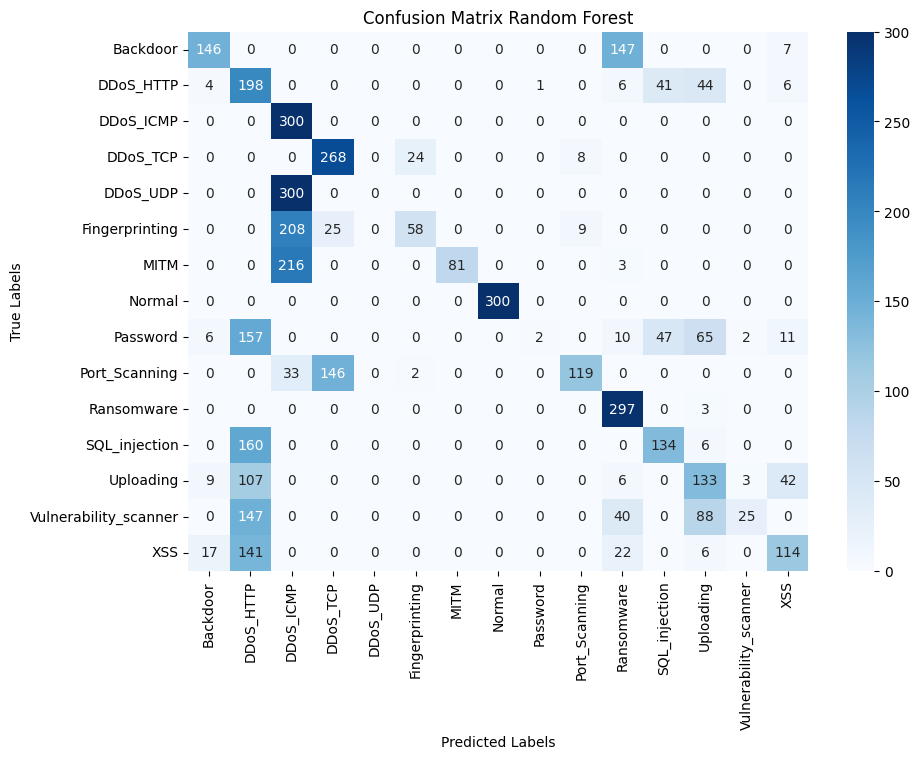

In [56]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest")
plt.show()

#### XGBOOST

In [57]:
# Initialize and Train XGBoost Model
model = xgb.XGBClassifier(
    n_estimators=100,  # Trees
    max_depth=6,       # Depth
    learning_rate=0.1,  # Learning rate
    subsample=0.8,      
    colsample_bytree=0.8, 
    random_state=42,
    use_label_encoder=False,  
    eval_metric="mlogloss"  
)

# Train model
model.fit(X_train, y_train)

# Make Predictions on Test Data
y_pred_xg = model.predict(X_test)

# Convert Predictions Back to Attack Names
y_test_labels = label_encoder.inverse_transform(y_test) 
y_pred_labels_xg = label_encoder.inverse_transform(y_pred_xg) 

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_xg)
report = classification_report(y_test_labels, y_pred_labels_xg)  
f1 = f1_score(y_test, y_pred_xg, average="weighted")

# Print Results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(report)

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:27:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.5193
✅ F1-Score: 0.4942

📊 Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.67      0.92      0.77       300
            DDoS_HTTP       0.24      0.74      0.36       300
            DDoS_ICMP       0.28      1.00      0.44       300
             DDoS_TCP       0.62      0.95      0.75       300
             DDoS_UDP       0.00      0.00      0.00       300
       Fingerprinting       0.93      0.17      0.28       300
                 MITM       1.00      0.27      0.42       300
               Normal       1.00      1.00      1.00       300
             Password       0.47      0.07      0.12       300
        Port_Scanning       0.85      0.40      0.55       300
           Ransomware       0.79      0.53      0.63       300
        SQL_injection       0.58      0.46      0.51       300
            Uploading       0.67      0.37      0.47       300
Vulnerability_scanner       0.75      0.51      0.61 

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

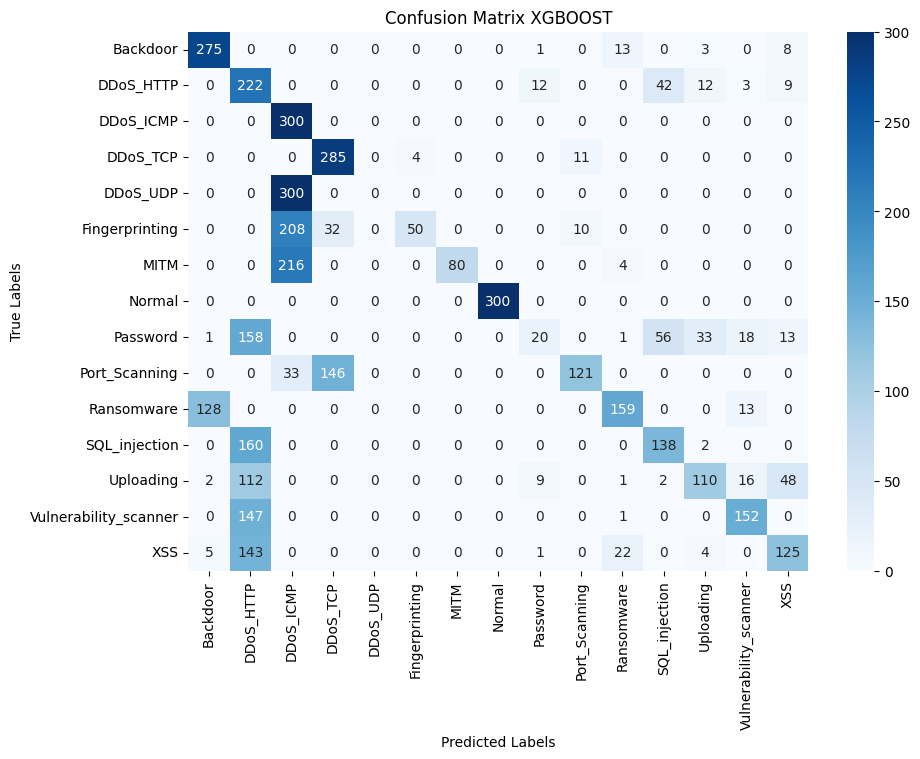

In [58]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix XGBOOST")
plt.show()

#### LIGHTBM

In [59]:
# Initialize and Train LightGBM Model
model = lgb.LGBMClassifier(
    n_estimators=300,  
    max_depth=-1,  
    learning_rate=0.05,  
    num_leaves=50, 
    min_data_in_leaf=10,  
    subsample=0.7,  
    colsample_bytree=0.7,  
    class_weight="balanced",  
    random_state=42
)

# Train the model
model.fit(X_train, y_train) 

# Make Predictions on Test Data
y_pred_lgbm = model.predict(X_test)

# Convert Predictions Back to Attack Names
y_test_labels = label_encoder.inverse_transform(y_test)  
y_pred_labels_lgbm = label_encoder.inverse_transform(y_pred_lgbm)  

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_lgbm)
report = classification_report(y_test_labels, y_pred_labels_lgbm) 
f1 = f1_score(y_test, y_pred_lgbm, average="weighted")

# Print Results
print(f"✅ Accuracy (LightGBM): {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report (LightGBM):")
print(report)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 16
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start tr

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

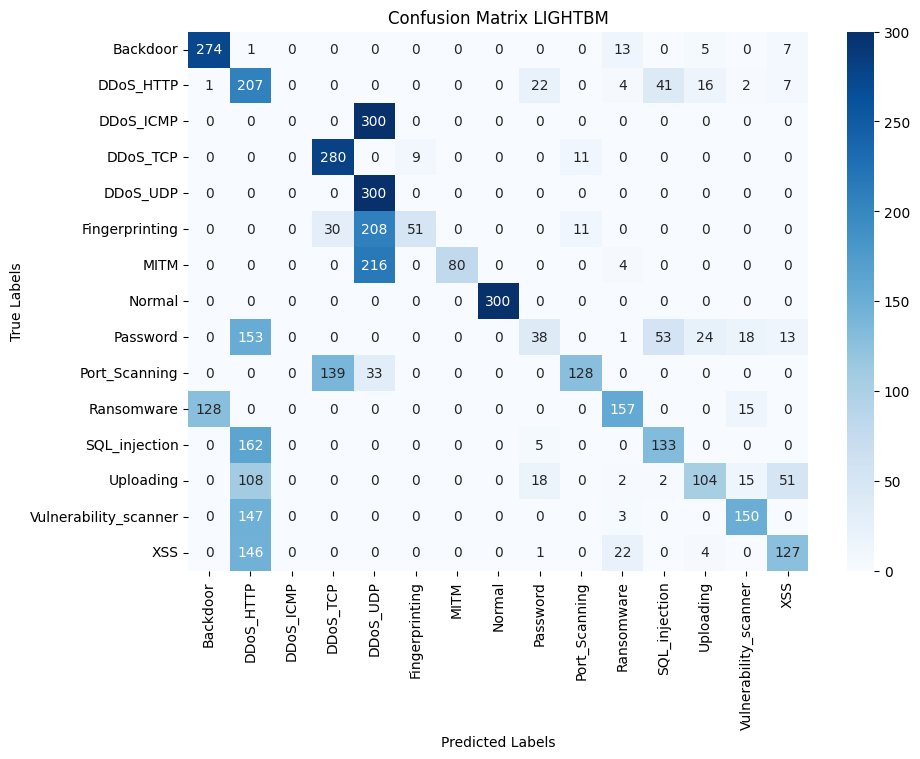

In [60]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix LIGHTBM")
plt.show()

#### MLP

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Improved MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        return self.output_layer(x)

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Configure model MLP
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
model = MLP(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model
epochs = 100
batch_size = 64
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Make Predictions on Test Data
with torch.no_grad():
    y_pred_mlp = model(X_test_tensor).argmax(dim=1).numpy()

# Convert Predictions Back to Attack Names
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels_mlp = label_encoder.inverse_transform(y_pred_mlp)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_mlp)
report = classification_report(y_test_labels, y_pred_labels_mlp, zero_division=0)
f1 = f1_score(y_test, y_pred_mlp, average="weighted")

# Print Results
print(f"✅ Accuracy (MLP): {accuracy:.4f}")
print(f"✅ F1-Score (MLP): {f1:.4f}")
print("\n📊 Classification Report (MLP):")
print(report)

Epoch 10/100, Loss: 1.3770
Epoch 20/100, Loss: 0.4754
Epoch 30/100, Loss: 0.4860
Epoch 40/100, Loss: 1.2583
Epoch 50/100, Loss: 0.6979
Epoch 60/100, Loss: 4.7874
Epoch 70/100, Loss: 0.2821
Epoch 80/100, Loss: 1.2265
Epoch 90/100, Loss: 0.4197
Epoch 100/100, Loss: 0.1605
✅ Accuracy (MLP): 0.2293
✅ F1-Score (MLP): 0.2033

📊 Classification Report (MLP):
                       precision    recall  f1-score   support

             Backdoor       0.13      0.27      0.17       300
            DDoS_HTTP       0.22      0.04      0.06       300
            DDoS_ICMP       0.21      0.77      0.33       300
             DDoS_TCP       0.32      0.13      0.18       300
             DDoS_UDP       0.18      0.12      0.14       300
       Fingerprinting       0.32      0.21      0.25       300
                 MITM       0.87      0.07      0.12       300
               Normal       1.00      0.97      0.99       300
             Password       0.12      0.31      0.17       300
        Port_Sca

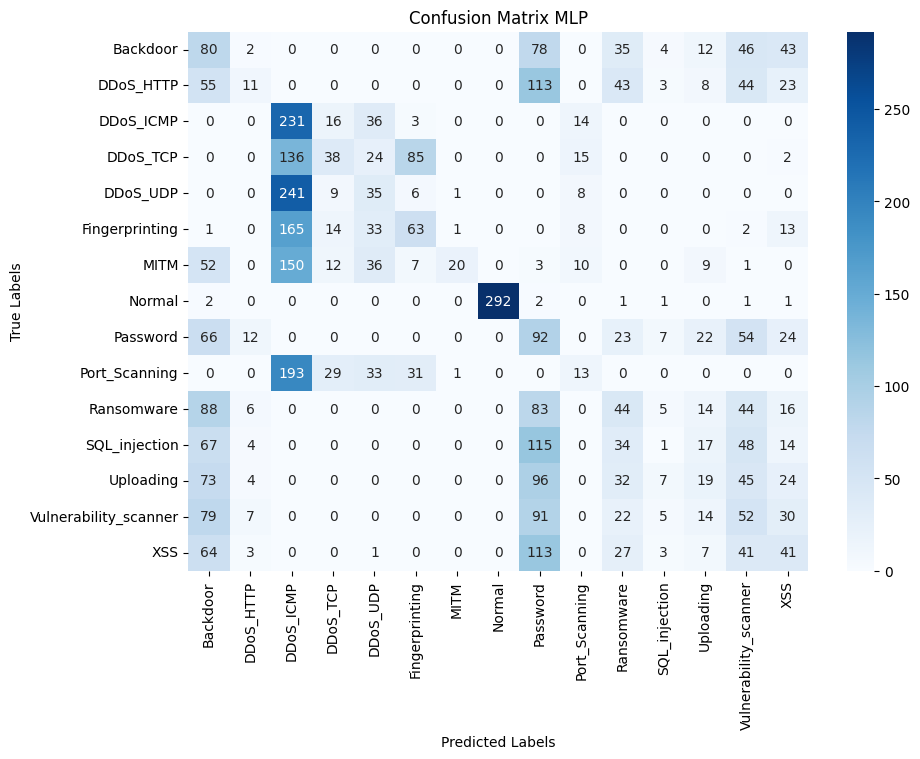

In [62]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix MLP")
plt.show()

### RESULTS COMPARISON

In [ ]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted")
    }

# Calculate metrics
metrics_mlp = compute_metrics(y_test_labels, y_pred_labels_mlp)
metrics_xgb = compute_metrics(y_test_labels, y_pred_labels_xg)
metrics_lgbm = compute_metrics(y_test_labels, y_pred_labels_lgbm)
metrics_rf = compute_metrics(y_test_labels, y_pred_labels_rf)

# Create dataframe
metrics_comparison_df = pd.DataFrame({
    "MLP": metrics_mlp,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgbm,
    "RandomForest": metrics_rf,
}).T  

# Show table
print(metrics_comparison_df)

              Accuracy  F1 Score  Precision    Recall
MLP           0.229333  0.203328   0.281726  0.229333
XGBoost       0.519333  0.494159   0.630476  0.519333
LightGBM      0.517556  0.497619   0.623950  0.517556
RandomForest  0.483333  0.443601   0.610755  0.483333


/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

: 